### M2 MVA - Computational Statistics
## TP 1 : Reminder on Markov Chains - Stochastic gradient descent

**Student**: Lucas Versini

**Exercise 3 : Stochastic Gradient Learning in Neural Networks**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**1.**

The real goal is to minimize the expected risk
$R(w) = \mathbb{E}\left[J(w, z)\right] = \displaystyle\int (y - {}^twx)^2 \, d\mathbb{P} (z)$.

Since this cannot be done in practice, because $\mathbb{P}$ is unknown, instead we want to minimize the empirical risk
$\displaystyle R_n(w) = \frac1n \sum_{i = 1}^n \left( y_i - {}^tw x_i \right)^2$.

The stochastic gradient algorithm is then the following:

> - Start with an initial $w_0 \in \mathbb{R}^d$ 
> - At each step $k = 1,\dots,n_{iter}$: <br>
> $~$ - Choose a random index $i \in [\![ 1, n ]\!]$ <br>
> $~$ - Set $w_{k+1} = w_k - \epsilon_k \nabla_w \left(\left( {}^tw x_i - y_i \right)^2\right)_{\mid w = w_k}$  

We can typically take $\varepsilon_k = \dfrac{1}{k^\alpha}$ for some $\alpha \in \left] \dfrac12, 1 \right]$.

And we have
$ \nabla_w \left(\left( {}^tw x_i - y_i \right)^2\right)
= 2 \left( {}^tw x_i - y_i \right) x_i$, so the update in the above algorithm becomes

$\boxed{w_{k+1} = w_k - \dfrac{2}{k^\alpha} \left( {}^tw x_i - y_i \right) x_i}$.

**Remarks**:

- Here it seems we only consider hyperplanes given by $w^T x = 0$ for some vector $w$, but we could also consider hyperplanes of the form ${}^t w x - \tau = 0$. However, instead of considering the vectors $x$, we could consider $(x^T, 1)^T$ and apply what was said above. We will do this for the last question.

- In the proof done in the lectures, we used an assumption, which here becomes $\mathbb{E} [ ({}^t w x - y )^2] \leq B^2$ for each $w$. We can reasonably assume that $x$ is bounded, but to make sure that $w$ remains bounded, we can project it onto the unit sphere.

We write a function `SGD(x, y, alpha, n_iter, projection = False)` which performs Stochastic Gradient Descent for data `x, y`. The initial $w$ is drawn according to $\mathcal{N}(0, {\bf I})$. `projection` is to decide whether to project $w$ onto the unit sphere (in practice we will not necessarly use it).

In [2]:
def SGD(x, y, alpha, n_iter, projection = False):
    """
    Stochastic Gradient Descent

    Parameters:
    x: data, numpy array with shape = (n_samples, n_features)
    y: target, numpy array with shape = (n_samples,)
    alpha: exponent for the learning rate
    n_iter: number of iterations

    Returns:
    final weights, numpy array with shape = (n_features,)
    """
    w = np.random.multivariate_normal(np.zeros(x.shape[1]), np.eye(x.shape[1]))
    
    for k in range(1, n_iter + 1):
        i = np.random.randint(0, len(y))
        x_i, y_i = x[i], y[i]
        
        w = w - 2 / k**alpha * (np.dot(x_i, w) - y_i) * x_i
        if projection:
            w = w / np.linalg.norm(w)
    return w

**2.** In the function `generate_dataset(n_samples, method = 'gaussian')`, we draw $\overline{w}$ a random vector on the unit sphere (but it could be chosen by the user), following the same distribution as $\left(\cos\Theta, \sin\Theta \right)$ where $\Theta \sim \mathcal{U}([0, 2\pi])$, and the data points are drawn either uniformly in $[-1, 1]^2$, or from a normal distribution.

In [3]:
def generate_dataset(n_samples, method = 'gaussian'):
    """
    Generate groundtruth vector, data and target

    Parameters:
    n_samples: number of samples
    method: method to generate the data, 'uniform' or 'gaussian'

    Returns:
    data (shape (n_samples, 2)), target (shape (n_samples,)), groundtruth vector (shape (2,))
    """

    # Generate a vector uniformly on the sphere
    theta = np.random.uniform(0, 2 * np.pi)
    w = np.array([np.cos(theta), np.sin(theta)])

    # Generate the data
    if method == 'uniform':
        x = np.random.uniform(-1, 1, (n_samples, 2))
    elif method == 'gaussian':
        x = np.random.multivariate_normal(np.zeros(2), np.eye(2), n_samples)
    else:
        raise ValueError('Unknown method to generate the data')
    
    # Generate the target
    y = np.sign(np.dot(x, w))

    return x, y, w

def plot_data(x, y, w, w_estimated = None):
    """
    Plot the data, the target hyperplane and the estimated hyperplane (if w_estimated is not None).
    
    Parameters:
    x: data (shape (n_samples, 2))
    y: target (shape (n_samples,))
    w: groundtruth vector (shape (2,))
    w_estimated: estimated vector (shape (2,)), default is None
    """
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1

    plt.figure()
    plt.scatter(x[y == 1, 0], x[y == 1, 1], color = 'red', label = 'y = 1')
    plt.scatter(x[y == -1, 0], x[y == -1, 1], color = 'blue', label = 'y = -1')
    plt.plot([x_min, x_max], [-(w[0] * x_min) / w[1], -(w[0] * x_max) / w[1]], color = 'black', label = r'$\overline{w}$')

    if w_estimated is not None:
        plt.plot([x_min, x_max], [-(w_estimated[0] * x_min) / w_estimated[1], -(w_estimated[0] * x_max) / w_estimated[1]],
                 color = 'green', label = r'$w^*$')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.title('Dataset')
    plt.show()

We plot an example with 200 points:

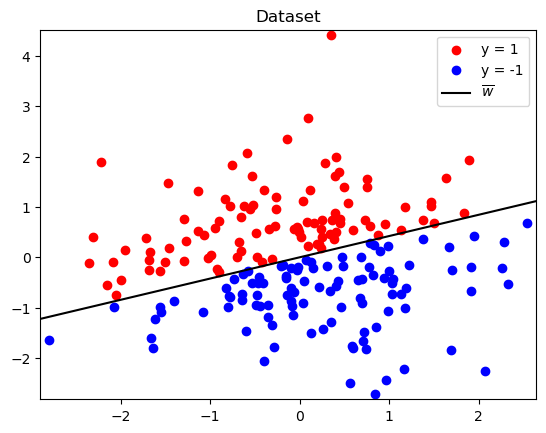

In [4]:
n_samples = 200

x, y, w = generate_dataset(n_samples)
plot_data(x, y, w)

**3.** We use the previous functions to compute $w^*$. We initialize the vector $w_0$ randomly.

In [5]:
def compute_accuracy(x, y, w):
    """
    Compute the accuracy of the model
    Parameters: x: data, y: target, w: weights
    Returns: accuracy
    """
    return np.mean(np.sign(np.dot(x, w)) == y)

The true vector is [-0.82185217 -0.5697008 ].
The (normalized) estimated vector is [-0.85902357 -0.51193603].
The accuracy is 0.990 and the distance between the true and estimated vectors is 0.069.


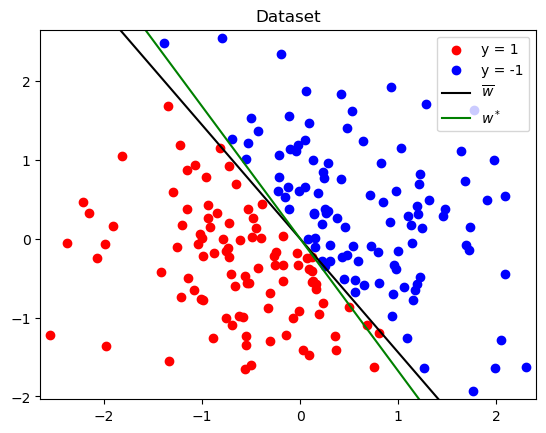

In [6]:
n_samples = 200
n_iter = 500
alpha = 0.8

x, y, w = generate_dataset(n_samples)

w_estimated = SGD(x, y, alpha, n_iter)
w_estimated /= np.linalg.norm(w_estimated)

print(f'The true vector is {w}.')
print(f'The (normalized) estimated vector is {w_estimated}.')

print(f'The accuracy is {np.mean(np.sign(np.dot(x, w_estimated)) == y):.3f} ', end = '')
print(f'and the distance between the true and estimated vectors is {np.linalg.norm(w - w_estimated):.3f}.')

plot_data(x, y, w, w_estimated)

We observe that $w^*$ is rather close to $\overline{w}$ and leads to an accuracy often higher than $97\%$ for $500$ iterations.

**4.**

In [7]:
def generate_dataset_noisy(n_samples, sigma = 0.1):
    """
    Generate groundtruth vector, data and target with noise

    n_samples: number of samples
    sigma: standard deviation of the noise

    return: data (shape (n_samples, 2)), target (shape (n_samples,)), groundtruth vector (shape (2,))
    """

    # Generate a vector uniformly on the sphere
    theta = np.random.uniform(0, 2 * np.pi)
    w = np.array([np.cos(theta), np.sin(theta)])

    # Generate the data and the target
    x = np.random.uniform(-1, 1, (n_samples, 2))
    y = 2. * (np.dot(x, w) > 0) - 1.

    # Add noise
    x = x + np.random.normal(0, sigma, (n_samples, 2))

    return x, y, w

The true vector is [-0.61252072 -0.79045453].
The (normalized) estimated vector is [-0.60218567 -0.79835607].
The accuracy is 0.90 and the distance between the true and estimated vectors is 0.01.


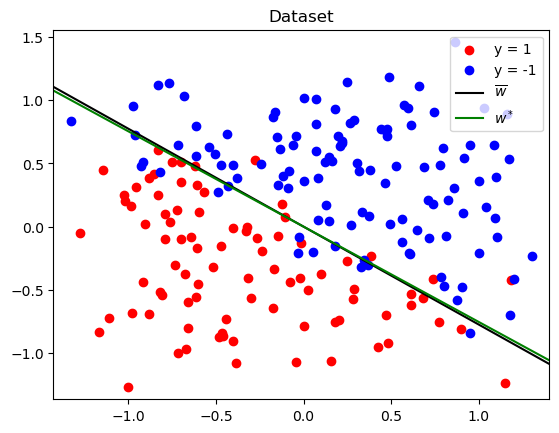

In [8]:
n_samples = 200
n_iter = 500
alpha = 0.8
sigma = 0.2

x, y, w = generate_dataset_noisy(n_samples, sigma)

w_estimated = SGD(x, y, alpha, n_iter)
w_estimated /= np.linalg.norm(w_estimated)

print(f'The true vector is {w}.')
print(f'The (normalized) estimated vector is {w_estimated}.')

print(f'The accuracy is {np.mean(np.sign(np.dot(x, w_estimated)) == y):.2f} ', end = '')
print(f'and the distance between the true and estimated vectors is {np.linalg.norm(w_estimated - w):.2f}.')

plot_data(x, y, w, w_estimated)

The accuracy is lower than before, typically between $92\%$ and $94\%$. This makes sense, considering that there may not exist a linear separation between the two classes.

What we can do is plot the accuracy and $\| w^* - \overline{w} \|$ for different values of $\sigma$. For the accuracy, we plot the accuracy of $\overline{w}$ but also the accuracy of $w^*$.

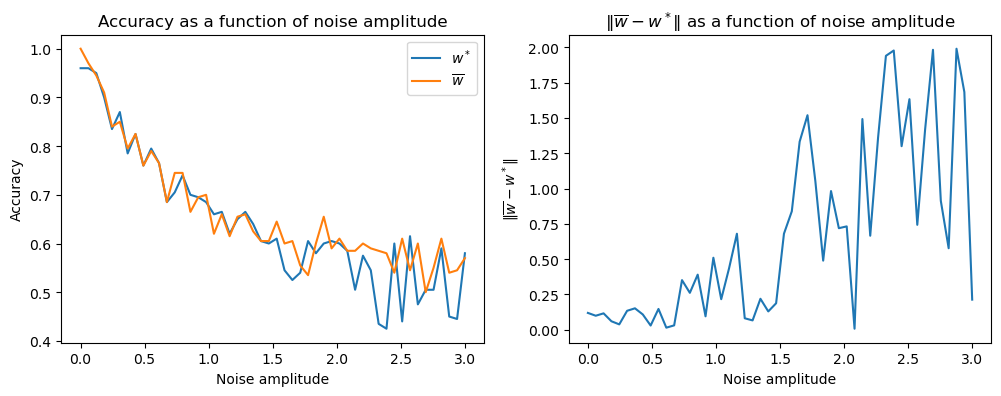

In [9]:
sigma_array = np.linspace(0, 3., 50)

accuracy = np.zeros((len(sigma_array), 2))
distance = np.zeros(len(sigma_array))

for i in range(len(sigma_array)):
    x, y, w = generate_dataset_noisy(n_samples, sigma_array[i])
    
    w_estimated = SGD(x, y, alpha, n_iter)
    w_estimated /= np.linalg.norm(w_estimated)

    accuracy[i, 0] = np.mean(np.sign(np.dot(x, w_estimated)) == y)
    distance[i] = np.linalg.norm(w_estimated - w)

    accuracy[i, 1] = np.mean(np.sign(np.dot(x, w)) == y)

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(sigma_array, accuracy[:, 0], label = r'$w^*$')
plt.plot(sigma_array, accuracy[:, 1], label = r'$\overline{w}$')
plt.xlabel('Noise amplitude')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of noise amplitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma_array, distance)
plt.xlabel('Noise amplitude')
plt.ylabel(r'$\| \overline{w} - w^* \|$')
plt.title(r'$\| \overline{w} - w^* \|$ as a function of noise amplitude')

plt.show()

When the noise increases, the accuracy of both $w$ and $w^*$ decreases.

We notice that for a noise with small amplitude, $\overline{w}$ is better than $w^*$, but after that it fluctuates: the noise is large, so $\overline{w}$ is not necessarily the best linear separation.

So the score of $w^*$ reduces, but so does the score of $\overline{w}$. And when the amplitude of the noise is too large, the accuracy is around $50\%$: the link between the features and the label is lost.

And we notice that the larger the noise is, the larger $\| \overline{w} - w^* \|$ can be (but bounded by $2$ since the vectors are normalized).

Note however that these results are random, and to get more stability one could do the experiments several times and average them.

**5.** We import the dataset, normalize the features so that they are between $0$ and $1$ (we could use more complex normalization schemes, using `sklearn.preprocessing.StandardScaler`, but let us stay simple), and change the labels from 'M' and 'B' to $1$ and $-1$ respectively.

In [10]:
# Get the features
data = np.loadtxt('wdbc.data', delimiter = ',', usecols = range(2, 32), dtype = np.float64)

# Normalize the features
data_min, data_max = np.min(data, axis = 0), np.max(data, axis = 0)
data = (data - data_min) / (data_max - data_min)

# Get the label and encode it as 1 for M and -1 for B
label_str = np.loadtxt('wdbc.data', delimiter = ',', usecols = 1, dtype = str)
label = (label_str == 'M') * 2. - 1.

print(f'The data has {data.shape[0]} samples and {data.shape[1]} features.')

The data has 569 samples and 30 features.


We then perform SGD.

In [11]:
w_estimated = SGD(data, label, 0.6, 20000)
w_estimated /= np.linalg.norm(w_estimated)

accuracy = np.mean(np.sign(np.dot(data, w_estimated)) == label)
print(f'The accuracy is {accuracy:.2f}.')

The accuracy is 0.92.


By running the code a few times, we easily reach an accuracy of $0.95$: the model is wrong less than $5\%$ of the time.

We can also, as stated at the beginning of this notebook, replace $x$ by $(1, x^T)^T$ to use affine functions, and not just linear ones.

In [12]:
data_aug = np.ones((data.shape[0], data.shape[1] + 1))
data_aug[:, 1:] = data

w_estimated = SGD(data_aug, label, 0.6, 20000)
w_estimated /= np.linalg.norm(w_estimated)

accuracy = np.mean(np.sign(np.dot(data_aug, w_estimated)) == label)
print(f'The accuracy is {accuracy:.2f}.')

The accuracy is 0.95.


We see that, even though we can reach low values for the accuracy (around $60\%$), we can also get about $97\%$ depending on the execution.

**Small extension**: If we want to proceed like people usually proceed in Machine Learning, we can train the model on $70\%$ of the data, and assess its quality on the remaining $30\%$.

In [13]:
try:
    from sklearn.model_selection import train_test_split

    # Split the data into a training and a test set
    data_train, data_test, label_train, label_test = train_test_split(data, label, test_size = 0.3)

    # Perform SGD
    w_estimated = SGD(data_train, label_train, 0.5, 10000)
    w_estimated /= np.linalg.norm(w_estimated)

    # Print the accuracy
    accuracy = np.mean(np.sign(np.dot(data_test, w_estimated)) == label_test)
    print(f'The accuracy on the validation set is {accuracy:.2f}')
except ModuleNotFoundError:
    print("It seems sklearn is not installed.")

The accuracy on the validation set is 0.91


So the accuracy is high as well here (we can here again reach $95\%$). We can have a look more in detail by computing the number of True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN):

In [14]:
TP = np.sum((np.dot(data_test, w_estimated) > 0) * (label_test == 1))
TN = np.sum((np.dot(data_test, w_estimated) <= 0) * (label_test == -1))
FP = np.sum((np.dot(data_test, w_estimated) > 0) * (label_test == -1))
FN = np.sum((np.dot(data_test, w_estimated) <= 0) * (label_test == 1))

print(f'TP = {TP}, TN = {TN}, FP = {FP}, FN = {FN}')

precision = TP / (TP + FP)
recall = TP / (TP + FN)
print(f'Precision = {precision:.2f}, Recall = {recall:.2f}')

TP = 59, TN = 96, FP = 2, FN = 14
Precision = 0.97, Recall = 0.81


What we usually notice is that the precision is high (ie when the model says the cancer is malignant, it is almost always true), but the recall is lower (the model misses some malignant cancers).

In practice, we would probably prefer to have few False Negatives to avoid thinking someone is healthy when they're not (False Positives are not great either, but further exams would eventually reveal the truth).